# Chat LangGraph

Deep dive on composition of LangGraph docs to inform indexing.

## Index Design

### Documentation Loading & Analysis

Follow what [is done](https://github.com/langchain-ai/chat-langchain/blob/master/backend/ingest.py) in `ChatLangChain`.

In [1]:
import re
import asyncio
import nest_asyncio
from typing import Generator
from bs4 import BeautifulSoup, SoupStrainer
from bs4 import BeautifulSoup, Doctype, NavigableString, Tag
from langchain.document_loaders import RecursiveUrlLoader, SitemapLoader

%matplotlib inline

def metadata_extractor(html: str, url: str) -> dict:
    soup = BeautifulSoup(html, "lxml")
    title = soup.find("title")
    description = soup.find("meta", attrs={"name": "description"})
    html = soup.find("html")
    return {
        "source": url,
        "title": title.get_text() if title else "",
        "description": description.get("content", "") if description else "",
        "language": html.get("lang", "") if html else "",
    }

def langchain_docs_extractor(html: str) -> str:
    soup = BeautifulSoup(html, "lxml")
    # Remove all the tags that are not meaningful for the extraction.
    SCAPE_TAGS = ["nav", "footer", "aside", "script", "style"]
    [tag.decompose() for tag in soup.find_all(SCAPE_TAGS)]

    def get_text(tag: Tag) -> Generator[str, None, None]:
        for child in tag.children:
            if isinstance(child, Doctype):
                continue

            if isinstance(child, NavigableString):
                yield child
            elif isinstance(child, Tag):
                if child.name in ["h1", "h2", "h3", "h4", "h5", "h6"]:
                    yield f"{'#' * int(child.name[1:])} {child.get_text()}\n\n"
                elif child.name == "a":
                    yield f"[{child.get_text(strip=False)}]({child.get('href')})"
                elif child.name == "img":
                    yield f"![{child.get('alt', '')}]({child.get('src')})"
                elif child.name in ["strong", "b"]:
                    yield f"**{child.get_text(strip=False)}**"
                elif child.name in ["em", "i"]:
                    yield f"_{child.get_text(strip=False)}_"
                elif child.name == "br":
                    yield "\n"
                elif child.name == "code":
                    parent = child.find_parent()
                    if parent is not None and parent.name == "pre":
                        classes = parent.attrs.get("class", "")

                        language = next(
                            filter(lambda x: re.match(r"language-\w+", x), classes),
                            None,
                        )
                        if language is None:
                            language = ""
                        else:
                            language = language.split("-")[1]

                        lines: list[str] = []
                        for span in child.find_all("span", class_="token-line"):
                            line_content = "".join(
                                token.get_text() for token in span.find_all("span")
                            )
                            lines.append(line_content)

                        code_content = "\n".join(lines)
                        yield f"```{language}\n{code_content}\n```\n\n"
                    else:
                        yield f"`{child.get_text(strip=False)}`"

                elif child.name == "p":
                    yield from get_text(child)
                    yield "\n\n"
                elif child.name == "ul":
                    for li in child.find_all("li", recursive=False):
                        yield "- "
                        yield from get_text(li)
                        yield "\n\n"
                elif child.name == "ol":
                    for i, li in enumerate(child.find_all("li", recursive=False)):
                        yield f"{i + 1}. "
                        yield from get_text(li)
                        yield "\n\n"
                elif child.name == "div" and "tabs-container" in child.attrs.get(
                    "class", [""]
                ):
                    tabs = child.find_all("li", {"role": "tab"})
                    tab_panels = child.find_all("div", {"role": "tabpanel"})
                    for tab, tab_panel in zip(tabs, tab_panels):
                        tab_name = tab.get_text(strip=True)
                        yield f"{tab_name}\n"
                        yield from get_text(tab_panel)
                elif child.name == "table":
                    thead = child.find("thead")
                    header_exists = isinstance(thead, Tag)
                    if header_exists:
                        headers = thead.find_all("th")
                        if headers:
                            yield "| "
                            yield " | ".join(header.get_text() for header in headers)
                            yield " |\n"
                            yield "| "
                            yield " | ".join("----" for _ in headers)
                            yield " |\n"

                    tbody = child.find("tbody")
                    tbody_exists = isinstance(tbody, Tag)
                    if tbody_exists:
                        for row in tbody.find_all("tr"):
                            yield "| "
                            yield " | ".join(
                                cell.get_text(strip=True) for cell in row.find_all("td")
                            )
                            yield " |\n"

                    yield "\n\n"
                elif child.name in ["button"]:
                    continue
                else:
                    yield from get_text(child)

    joined = "".join(get_text(soup))
    return re.sub(r"\n\n+", "\n\n", joined).strip()

nest_asyncio.apply()

def load_docs():
    loader = RecursiveUrlLoader(
        "https://langchain-ai.github.io/langgraph",
        extractor=langchain_docs_extractor,
        metadata_extractor=metadata_extractor,
        max_depth=10
    )
    docs = loader.load()
    return docs

docs = load_docs()
docs_texts = [d.page_content for d in docs]
len(docs)

USER_AGENT environment variable not set, consider setting it to identify your requests.


252

### Overview of docs
 
* Visualize tokens per doc
* Clean outliers

In [2]:
import pandas as pd
import tiktoken

def num_tokens_from_string(string: str, encoding_name: str) -> int:
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens

docs_data = []
for doc in docs:
    doc_text = doc.page_content  # Getting text from each document
    tokens = num_tokens_from_string(doc_text, "cl100k_base")  # Calculate tokens
    char_count = len(doc_text)  # Calculate character count
    source = doc.metadata['source']  # Extract source from metadata
    docs_data.append({
        'doc_text': doc_text,
        'tokens': tokens,
        'char_count': char_count,  # Add character count here
        'source': source
    })

docs_df = pd.DataFrame(docs_data)
exclude = []
docs_df_clean=docs_df[~docs_df.index.isin(exclude)].copy()

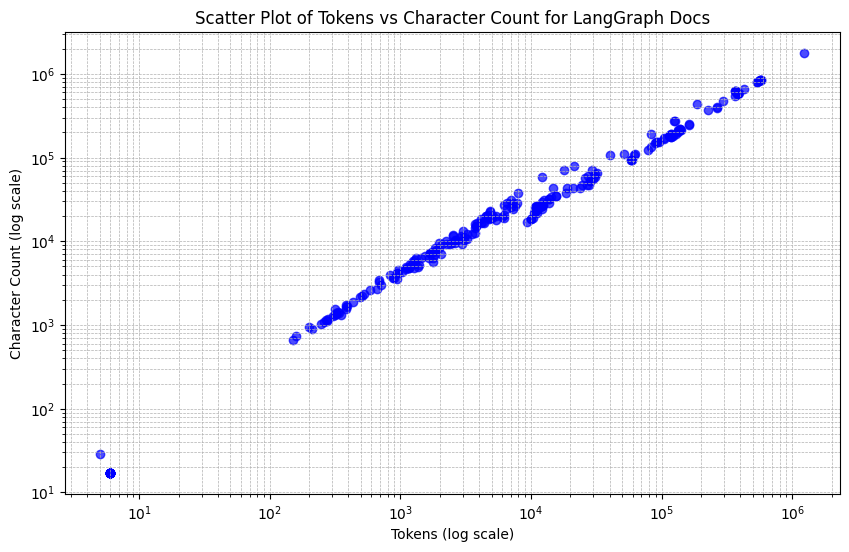

In [3]:
import matplotlib.pyplot as plt
# Tokens vs chars
plt.figure(figsize=(10, 6))
plt.scatter(docs_df_clean['tokens'], docs_df_clean['char_count'], color="blue", alpha=0.7)
plt.xscale('log')
plt.yscale('log')
plt.title("Scatter Plot of Tokens vs Character Count for LangGraph Docs")
plt.xlabel("Tokens (log scale)")
plt.ylabel("Character Count (log scale)")
plt.grid(True, which="both", ls="--", linewidth=0.5)

In [37]:
def get_doc_type(url):
    if 'langgraphjs' in url:
        parts = url.split('https://langchain-ai.github.io/langgraphjs/')
    else:
        parts = url.split('https://langchain-ai.github.io/langgraph/')
    if len(parts) > 1:
        return parts[1].split('/')[0]
    return 'Landing Page'

# Add a new column 'language' to docs_df_clean
docs_df_clean['language'] = docs_df_clean['source'].apply(
    lambda x: 'js' if 'langgraphjs' in x.lower() else 'python'
)

# Apply the function to create the 'doc_type' column
docs_df_clean['doc_type'] = docs_df_clean['source'].apply(get_doc_type)

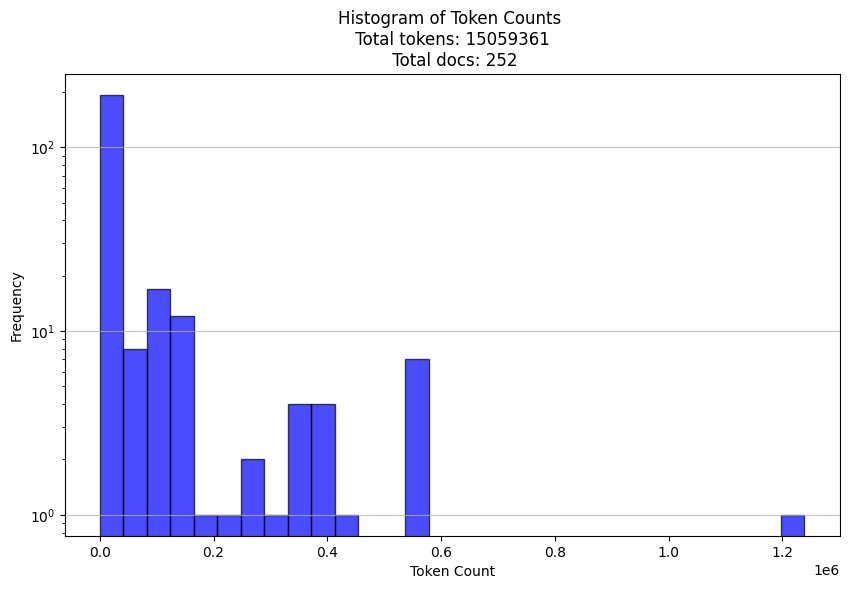

In [38]:
# Calculate the number of tokens for each document
plt.figure(figsize=(10, 6))
plt.hist(docs_df_clean['tokens'], bins=30, color="blue", edgecolor="black", alpha=0.7)
total_tok = docs_df_clean.tokens.sum()
total_docs = docs_df_clean.shape[0]
plt.title(f"Histogram of Token Counts \n Total tokens: {total_tok} \n Total docs: {total_docs}")
plt.xlabel("Token Count")
plt.ylabel("Frequency")
plt.grid(axis="y", alpha=0.75)
plt.yscale('log')

/var/folders/l9/bpjxdmfx7lvd1fbdjn38y5dh0000gn/T/ipykernel_82193/2326669627.py:38: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


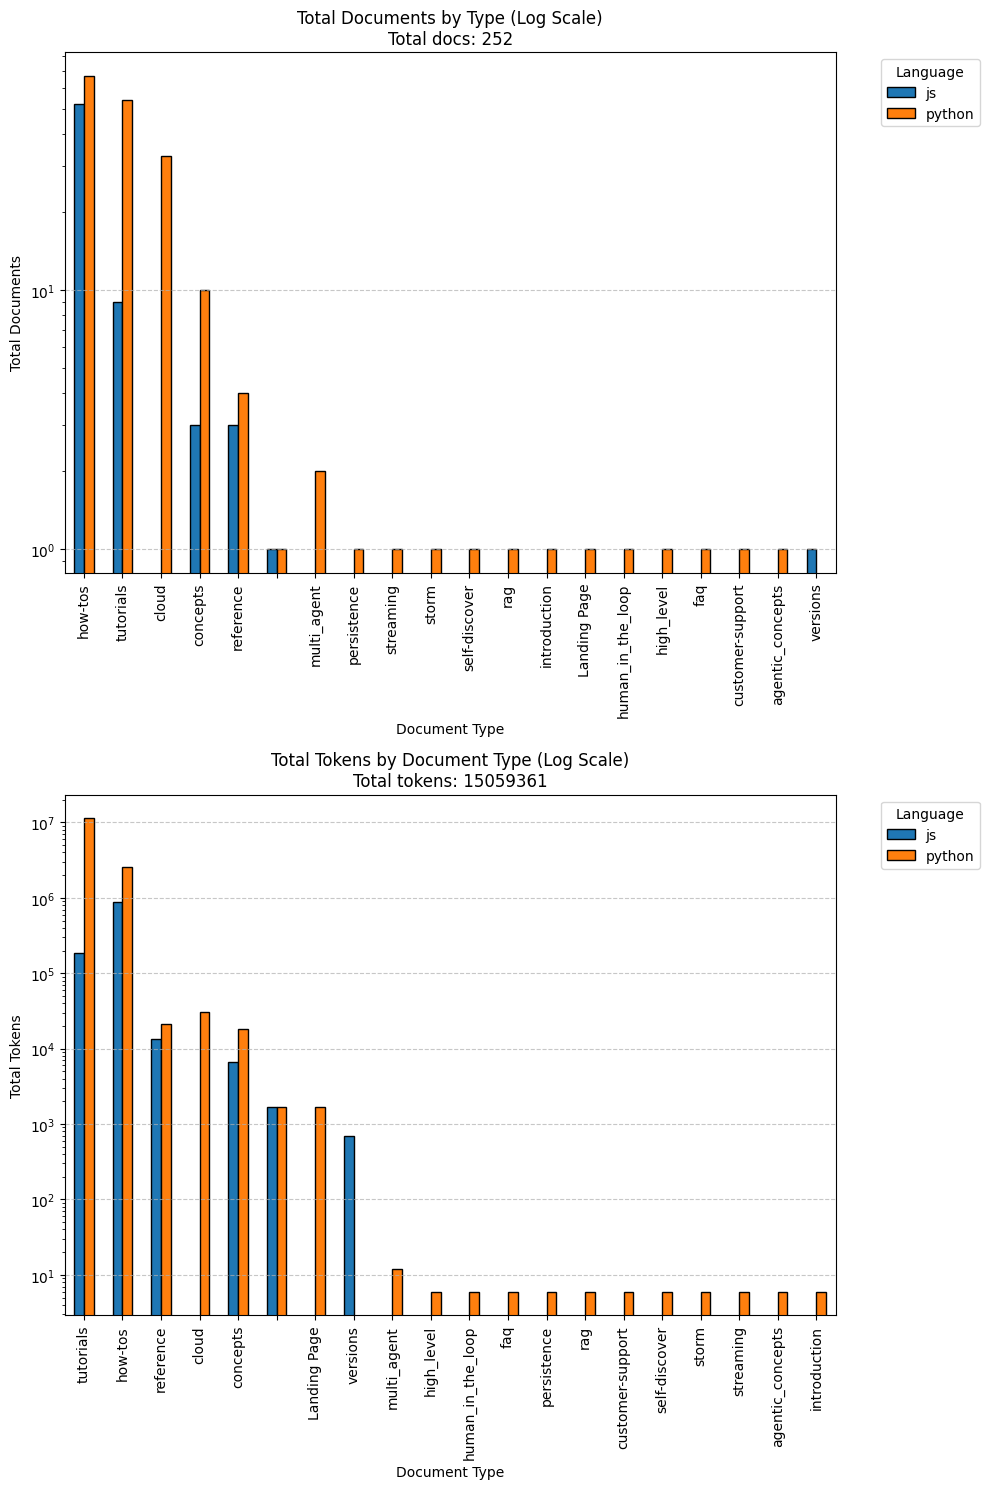

In [39]:
def plt_doc_num_and_tok(df):
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 15))

    total_tok = df.tokens.sum()
    total_docs = df.shape[0]

    # First subplot for Total Documents by Type
    doc_counts = df.groupby(['doc_type', 'language']).size().unstack(fill_value=0)
    doc_counts['total'] = doc_counts.sum(axis=1)
    doc_counts_sorted = doc_counts.sort_values('total', ascending=False).drop('total', axis=1)
    doc_counts_sorted.plot(kind='bar', ax=ax1, edgecolor='black')
    ax1.set_title(f'Total Documents by Type (Log Scale)\nTotal docs: {total_docs}')
    ax1.set_xlabel('Document Type')
    ax1.set_ylabel('Total Documents')
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
    ax1.grid(axis='y', linestyle='--', alpha=0.7)
    ax1.set_yscale('log')
    ax1.legend(title='Language', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Second subplot for Total Tokens by Document Type
    token_counts = df.groupby(['doc_type', 'language'])['tokens'].sum().unstack(fill_value=0)
    token_counts['total'] = token_counts.sum(axis=1)
    token_counts_sorted = token_counts.sort_values('total', ascending=False).drop('total', axis=1)
    token_counts_sorted.plot(kind='bar', ax=ax2, edgecolor='black')
    ax2.set_title(f'Total Tokens by Document Type (Log Scale)\nTotal tokens: {total_tok}')
    ax2.set_xlabel('Document Type')
    ax2.set_ylabel('Total Tokens')
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)
    ax2.grid(axis='y', linestyle='--', alpha=0.7)
    ax2.set_yscale('log')
    ax2.legend(title='Language', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    return fig

fig = plt_doc_num_and_tok(docs_df_clean)
fig.show()

Let's tier our docs for index design

In [33]:
docs_df_clean.head()

,doc_text,tokens,char_count,source,doc_type,language
0,ü¶úüï∏Ô∏èLangGraph\n\n[\n Skip to c...,1695,7252,https://langchain-ai.github.io/langgraph,Unknown,python
1,Tutorials\n\n[\n Skip to content\n ...,870,3669,https://langchain-ai.github.io/langgraph/tutor...,tutorials,python
2,SQL Agent\n\n[\n Skip to content\n ...,379788,580711,https://langchain-ai.github.io/langgraph/tutor...,tutorials,python
3,Adaptive RAG\n\n[\n Skip to content\n...,137960,220299,https://langchain-ai.github.io/langgraph/tutor...,tutorials,python
4,Graphs\n\n[\n Skip to content\n ...,6536,28729,https://langchain-ai.github.io/langgraph/refer...,reference,python


Ideas:

* Split js vs python 
* Remove notebook cells outputs 
* Narrow down to `how-to`, `concepts`, `tutorials`
* Can likely context stuff them (no index) or simple doc-wise retrieval w/ page summary (parent-document) 

